In [2]:
import network_design as nd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
from itertools import combinations
import copy
import matplotlib.colors as mpl
from matplotlib import animation
# !module load graph-tool
import graph_tool.all as gt


In [2]:
def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

In [19]:
g = nx.fast_gnp_random_graph(10,.1)

In [20]:
X = nd.label_network(g,'automorphic')

In [24]:
np.unique(np.array([[1,2],[3,4]]))

array([1, 2, 3, 4])

In [110]:
g = nx.random_tree(20)
h = copy.deepcopy(g)
for i in h.nodes():
    neighbors = g.neighbors(i)
    neighbor_pairs = list(combinations(neighbors,2))
    h.add_edges_from(neighbor_pairs)

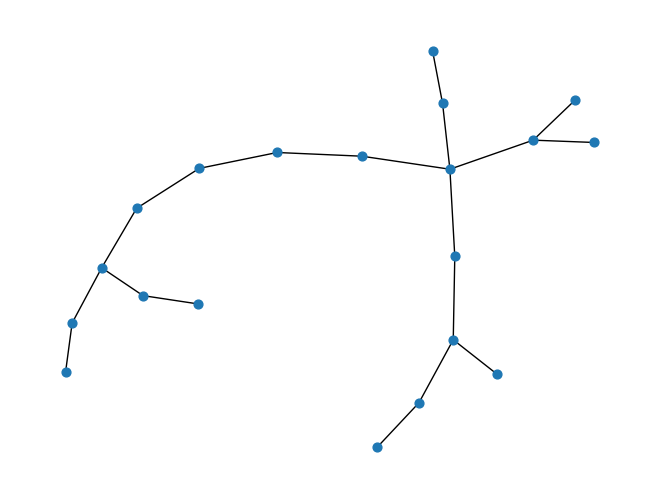

In [111]:
# g = nx.cycle_graph(20)
nx.draw(g,node_size=40)
# g.add_edge(0,5)

In [26]:
def get_automorphic_groups_nx(graph):
    """
    Retrieve groups of automorphic vertices in the graph using NetworkX.
    """
    # Initialize a graph matcher
    GM = nx.isomorphism.GraphMatcher(graph, graph)
    
    # Collect all automorphisms
    automorphisms = []
    for automorphism in GM.isomorphisms_iter():
        automorphisms.append(automorphism)
    
    # Initialize equivalence classes
    n = graph.number_of_nodes()
    groups = {i: {i} for i in range(n)}
    
    # Merge equivalent vertices based on automorphisms
    for auto in automorphisms:
        for v1, v2 in auto.items():
            groups[v1].add(v2)
            groups[v2].add(v1)
    
    # Extract unique groups
    unique_groups = {frozenset(group) for group in groups.values()}
    return [list(group) for group in unique_groups]

# Example Usage  # Example output: [[0, 1, 2, 3, 4]]


In [23]:
get_automorphic_groups_nx(g)

[[10],
 [1],
 [18],
 [14],
 [8],
 [13],
 [16],
 [11],
 [17],
 [9],
 [5],
 [15],
 [12],
 [4],
 [2],
 [7],
 [3],
 [6],
 [19],
 [0]]

In [20]:
g.add_edge(5,7)

In [112]:
# automorphic_groups = get_automorphic_groups_nx(g)
automorphic_groups = [[i] for i in range(20)]

In [1]:
# automorphic_groups.remove([4])
# automorphic_groups.remove([6])
# automorphic_groups.append([4,6])
X

NameError: name 'X' is not defined

In [114]:
X = np.zeros((g.number_of_nodes(),len(automorphic_groups)))

In [115]:
node_to_group = {}
for group_idx, group in enumerate(automorphic_groups):
    for node in group:
        node_to_group[node] = group_idx

# Step 2: Pre-allocate the matrix X (assuming g.nodes() is the list of nodes)
num_nodes = len(g.nodes())
X = np.zeros((num_nodes, len(automorphic_groups)))

# Step 3: Fill the matrix X using the precomputed node-to-group mapping
for i in g.nodes():
    group_idx = node_to_group[i]
    X[i, group_idx] = 1
            

In [120]:
non_edges = list(nx.non_edges(g))
idx = np.random.choice(np.arange(len(non_edges)))
u,v = non_edges[idx]
g.add_edge(u,v)

In [121]:
O=nd.create_O(nd.extract_capacities(g,X))    

/tmp/ipykernel_8775/630043136.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


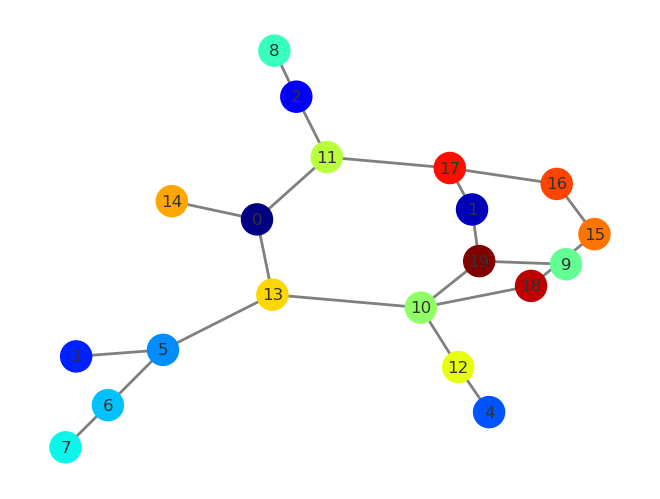

In [122]:
import matplotlib as mpl
unique_colors = np.arange(X.shape[1])
labels = np.argmax(X, axis=1) 

# Define the colormap
cmap = plt.cm.jet  # Use the 'jet' colormap
cmaplist = [cmap(i) for i in range(cmap.N)]  # Extract all colors from the colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Create the norm for the colormap
unique_colors = np.unique(labels)  # Unique label indices
bounds = np.linspace(0, len(unique_colors), len(unique_colors) + 1)  # Bounds for labels
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Assign colors to nodes based on labels
node_colors = [cmap(norm(label)) for label in labels]

# Draw the graph
pos = nx.spring_layout(g, seed=14)
nx.draw(
    g,
    pos,
    with_labels=True,
    node_size=500,
    node_color=node_colors,
    edge_color="grey",
    font_size=12,
    font_color="#333333",
    width=2,
)
plt.tight_layout()
plt.savefig('figs/drafts/v5/fig3/tree_x.pdf')
plt.show()

In [33]:
len(unique_colors)

10

In [34]:
colors = [cmap(norm(label)) for label in unique_colors]

In [38]:
new_X = np.vstack(tuple([X for _ in range(10)]))

/tmp/ipykernel_8775/2270588795.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


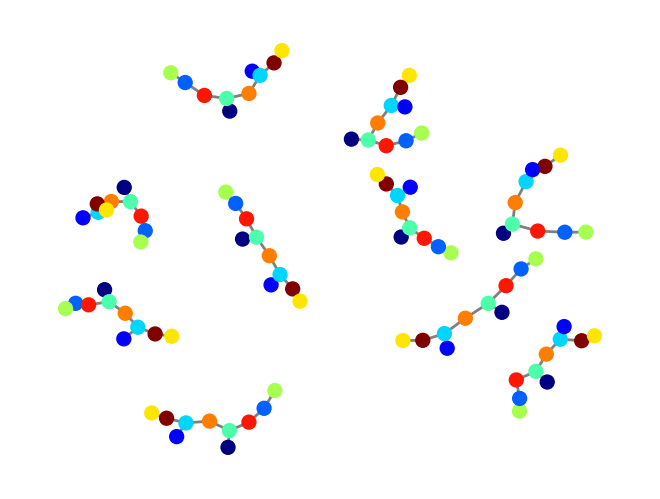

In [55]:
import matplotlib as mpl
unique_colors = np.arange(new_X.shape[1])
labels = np.argmax(new_X, axis=1) 

# Define the colormap
cmap = plt.cm.jet  # Use the 'jet' colormap
cmaplist = [cmap(i) for i in range(cmap.N)]  # Extract all colors from the colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Create the norm for the colormap
unique_colors = np.unique(labels)  # Unique label indices
bounds = np.linspace(0, len(unique_colors), len(unique_colors) + 1)  # Bounds for labels
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Assign colors to nodes based on labels
node_colors = [cmap(norm(label)) for label in labels]

# Draw the graph
new_g = nd.microcanonical_ensemble(new_X,O)
pos = nx.spring_layout(g)
nx.draw(
    g,
    pos,
    with_labels=False,
    node_size=100,
    node_color=node_colors,
    edge_color="grey",
    font_size=12,
    font_color="#333333",
    width=2,
)
plt.tight_layout()
plt.savefig('figs/drafts/v5/fig3/reconstruction.pdf')
plt.show()

In [58]:
dist = np.zeros(2)
import copy
g = nx.subgraph(test_g,sorted(list(nx.connected_components(test_g)),key=len,reverse=True)[0])
test_g = copy.deepcopy(g)
for _ in range(9):
    test_g = nx.disjoint_union(test_g,g)
# for _ in range(2):
    # new_g = nd.microcanonical_ensemble(new_X,O)
nx.is_isomorphic(test_g,new_g)

True

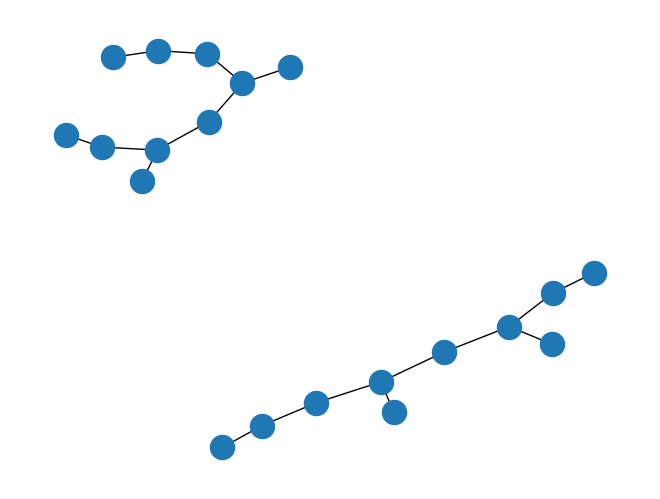

In [49]:
nx.draw(new_g)

In [41]:
import copy
test_g = copy.deepcopy(g)
for i in range(20):
    test_g = nx.disjoint_union(g,test_g)    

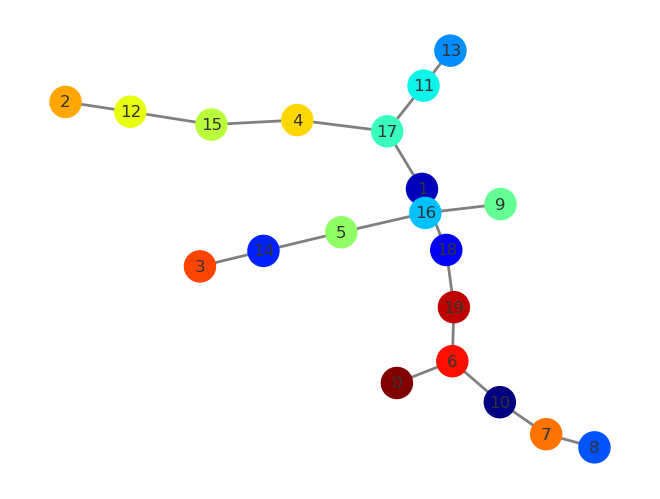

In [40]:
pos = nx.spring_layout(new_g, seed=14)
nx.draw(
    new_g,
    pos,
    with_labels=True,
    node_size=500,
    node_color=node_colors,
    edge_color="grey",
    font_size=12,
    font_color="#333333",
    width=2,
)
plt.show()

In [54]:
diffs = np.zeros((100,300))
cycle_basis = np.zeros((100,300))
for _ in range(100):
    g = nx.random_tree(100)
    automorphic_groups = get_automorphic_groups_nx(g)
    X = np.zeros((g.number_of_nodes(),len(automorphic_groups)))
    node_to_group = {}
    for group_idx, group in enumerate(automorphic_groups):
        for node in group:
            node_to_group[node] = group_idx
    
    # Step 2: Pre-allocate the matrix X (assuming g.nodes() is the list of nodes)
    num_nodes = len(g.nodes())
    X = np.zeros((num_nodes, len(automorphic_groups)))
    
    # Step 3: Fill the matrix X using the precomputed node-to-group mapping
    for i in g.nodes():
        group_idx = node_to_group[i]
        X[i, group_idx] = 1
    for k in range(300):
        O=nd.create_O(nd.extract_capacities(g,X))
        new_g = nd.microcanonical_ensemble(X,O)
        diffs[_,k] = np.linalg.norm(nx.adjacency_matrix(g).toarray() - nx.adjacency_matrix(new_g).toarray())
        cycle_basis[_,k] = len(nx.cycle_basis(g))
        non_edges = list(nx.non_edges(g))
        idx = np.random.choice(np.arange(len(non_edges)))
        u,v = non_edges[idx]
        g.add_edge(u,v)
        

KeyboardInterrupt: 

In [73]:
len(g.edges()), len(new_g.edges())

(101, 100)

In [55]:
print(_)

73


In [57]:
np.linalg.norm(nx.adjacency_matrix(g).toarray() - nx.adjacency_matrix(new_g).toarray()), k

(1.4142135623730951, 99)

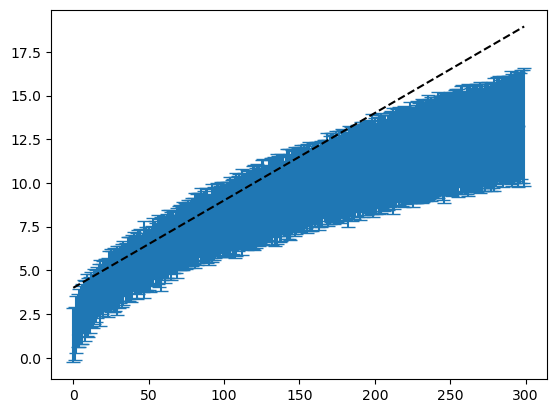

In [56]:
plt.plot(np.arange(300),np.mean(diffs[:50,:],axis=0))
plt.errorbar(np.arange(300),np.mean(diffs[:50,:],axis=0),yerr=np.std(diffs[:50,:],axis=0),capsize=5,color='tab:blue')
plt.plot(np.arange(300),np.arange(300)/20+4,'--',color='k')

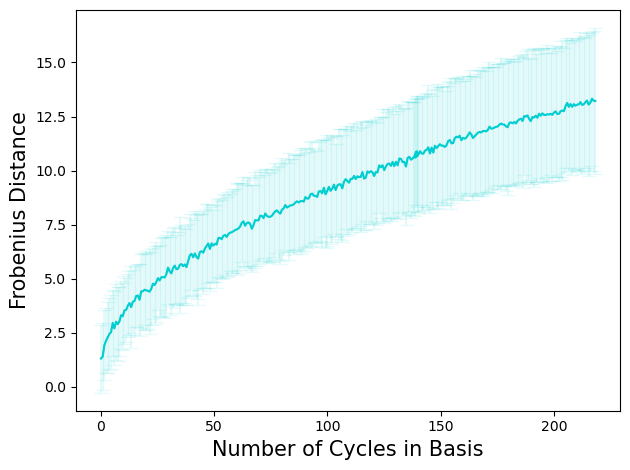

In [64]:
plt.plot(np.mean(cycle_basis,axis=0),np.mean(diffs[:50,:],axis=0),color='darkturquoise')
plt.errorbar(np.mean(cycle_basis,axis=0),np.mean(diffs[:50,:],axis=0),yerr=np.std(diffs[:50,:],axis=0),capsize=5,color='darkturquoise',alpha=.1)
plt.xlabel('Number of Cycles in Basis',fontsize=15)
plt.ylabel('Frobenius Distance',fontsize=15)
plt.tight_layout()
plt.savefig('figs/drafts/v5/fig3/cycle.pdf')
# plt.plot(np.mean(cycle_basis,axis=0),np.mean(cycle_basis,axis=0)/20+4,'--',color='k')
# plt.plot(np.arange(100),np.mean(diffs,axis=0))
# plt.errorbar(np.arange(100),np.mean(diffs,axis=0),yerr=np.std(diffs,axis=0),capsize=5,color='tab:orange')
# plt.plot(np.arange(100),np.arange(100)/20+4,'--',color='k')

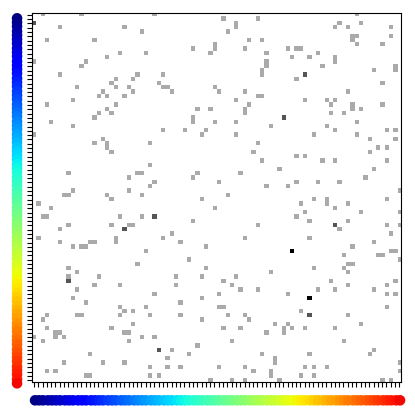

In [96]:
fig,ax = plt.subplots(1,1)
ax.imshow(O,cmap='binary')
ax.set_xticks(np.arange(X.shape[1]))
ax.set_xticklabels(['\u25CF' for _ in range(X.shape[1])])
for xtick, color in zip(ax.get_xticklabels(), colors):
    xtick.set_color(color)
ax.set_yticks(np.arange(X.shape[1]))
ax.set_yticklabels(['\u25CF' for _ in range(X.shape[1])])
for xtick, color in zip(ax.get_yticklabels(), colors):
    xtick.set_color(color)
plt.show()

In [41]:
# graph_coloring = nx.greedy_color(h,backend='independent_set')
# unique_colors = set(graph_coloring.values())

# # Assign colors to nodes based on the greedy coloring
# graph_color_to_mpl_color = dict(zip(unique_colors, mpl.colors.TABLEAU_COLORS))
# node_colors = [graph_color_to_mpl_color[graph_coloring[n]] for n in g.nodes()]

# pos = nx.spring_layout(g, seed=14)
# nx.draw(
#     g,
#     pos,
#     with_labels=True,
#     node_size=500,
#     node_color=node_colors,
#     edge_color="grey",
#     font_size=12,
#     font_color="#333333",
#     width=2,
# )
# plt.show()

In [17]:
X = np.eye(g.number_of_nodes())


In [60]:
g = nx.cycle_graph(4)
X = np.eye(4)
capacities = nd.extract_capacities(g,X)
O = nd.create_O(capacities)


In [63]:
new_G = nd.microcanonical_ensemble(np.vstack(tuple([X for _ in range(2)])),O)

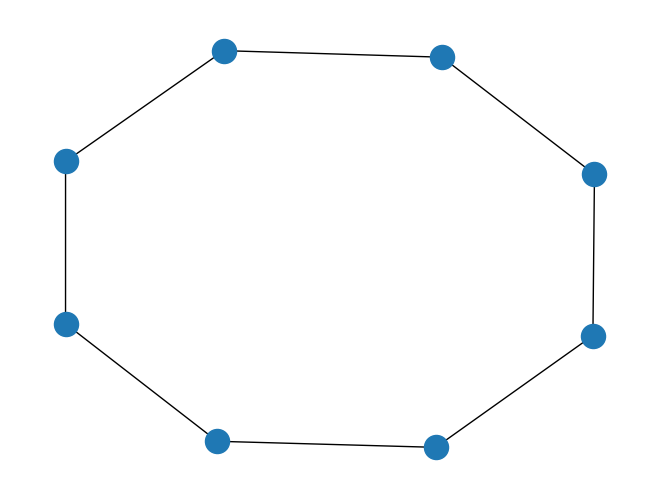

In [64]:
nx.draw(new_G)

In [65]:
def count_graph_occurrences(graph_count_list, new_graph):
    """
    Count occurrences of unique graphs based on isomorphism.

    Parameters:
        graph_count_list (list): List of tuples [(graph, count), ...].
        new_graph (nx.Graph): The new graph to check and count.

    Returns:
        None: Updates the graph_count_list in place.
    """
    for i, (existing_graph, count) in enumerate(graph_count_list):
        if nx.is_isomorphic(existing_graph, new_graph):
            graph_count_list[i] = (existing_graph, count + 1)  # Increment the count
            return

    # If no isomorphic graph is found, add the new graph with count 1
    graph_count_list.append((new_graph, 1))

In [5]:
def count_graph_occurrences_labeled(graph_count_list, new_graph):
    """
    Count occurrences of unique graphs based on isomorphism.

    Parameters:
        graph_count_list (list): List of tuples [(graph, count), ...].
        new_graph (nx.Graph): The new graph to check and count.

    Returns:
        None: Updates the graph_count_list in place.
    """
    for i, (existing_graph, count) in enumerate(graph_count_list):
        if np.allclose(nx.adjacency_matrix(existing_graph).toarray(),nx.adjacency_matrix(new_graph).toarray()):
            graph_count_list[i] = (existing_graph, count + 1)  # Increment the count
            return

    # If no isomorphic graph is found, add the new graph with count 1
    graph_count_list.append((new_graph, 1))

In [88]:
graphs = []
for i in range(1000):
    new_G = nd.microcanonical_ensemble(np.vstack(tuple([X for _ in range(4)])),O)
    count_graph_occurrences(graphs,new_G)
    
    

In [87]:
len(graphs)

5

In [89]:
count = np.array([count for _, count in graphs])

Text(0, 0.5, '$P(G)$')

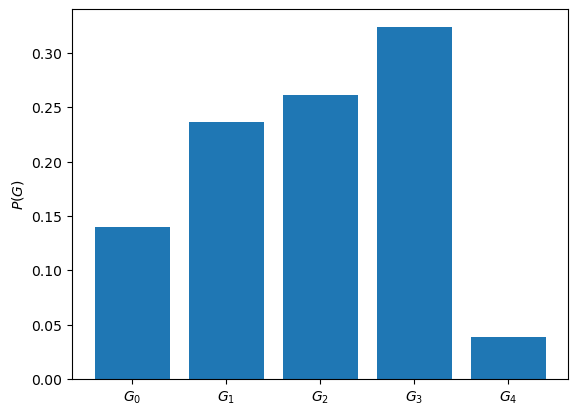

In [109]:
plt.bar(np.arange(len(graphs)),count/count.sum())
plt.xticks([0,1,2,3,4],[f'$G_{i}$' for i in range(5)])
plt.ylabel('$P(G)$')

In [91]:
unique = np.unique([len(nx.cycle_basis(g[0])) for g in graphs])
cycle_len = [len(nx.cycle_basis(g[0])) for g in graphs]

In [87]:
idx = [np.where([len(nx.cycle_basis(g[0])) for g in graphs] == i)[0] for i in np.unique([len(nx.cycle_basis(g[0])) for g in graphs])]
idx

[array([0]),
 array([2, 3, 8]),
 array([1, 4, 9]),
 array([6, 7]),
 array([5]),
 array([10])]

<ErrorbarContainer object of 3 artists>

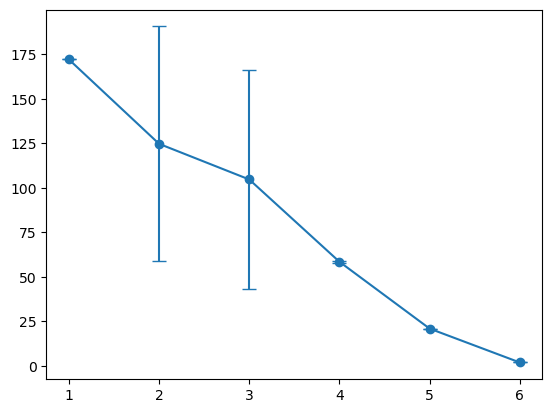

In [102]:
plt.plot(unique,[np.mean(count[i]) for i in idx],'o')
plt.errorbar(unique,[np.mean(count[i]) for i in idx],yerr=[np.std(count[i]) for i in idx],capsize=5,color='tab:blue')

In [63]:
graphs[0][0].edges()

EdgeView([(0, 19), (0, 5), (1, 10), (1, 16), (2, 13), (2, 15), (3, 8), (3, 6), (4, 7), (4, 13), (5, 18), (6, 17), (7, 18), (8, 17), (9, 12), (9, 14), (10, 19), (11, 14), (11, 12), (15, 16)])

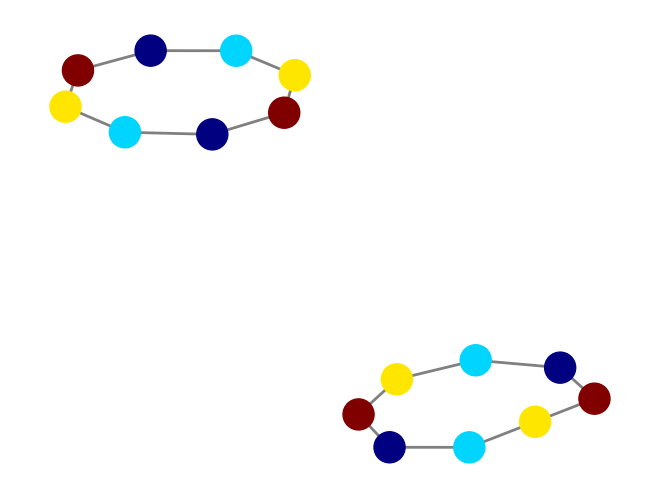

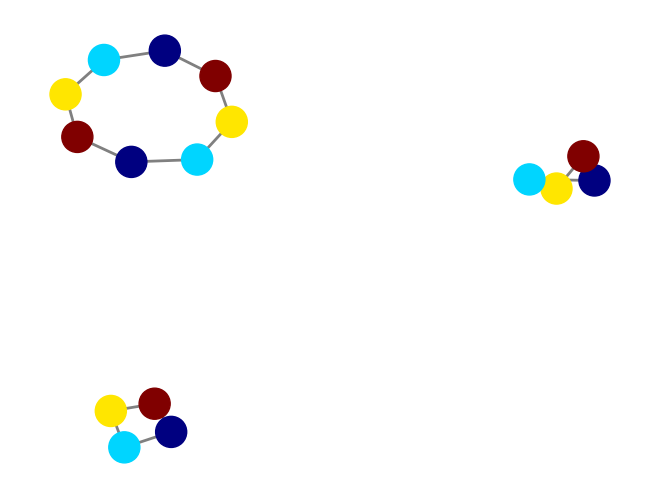

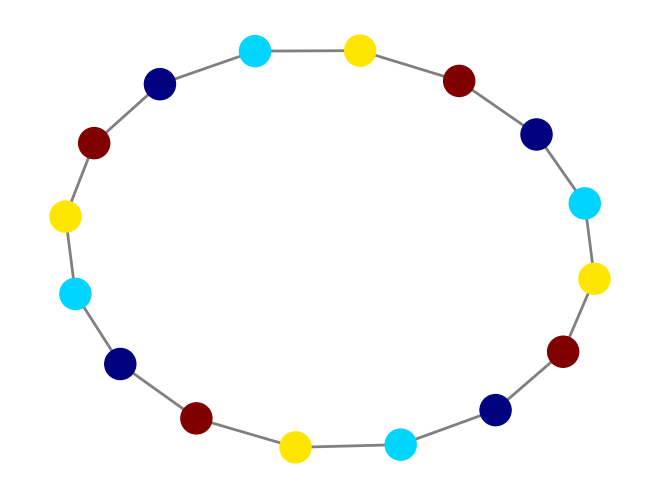

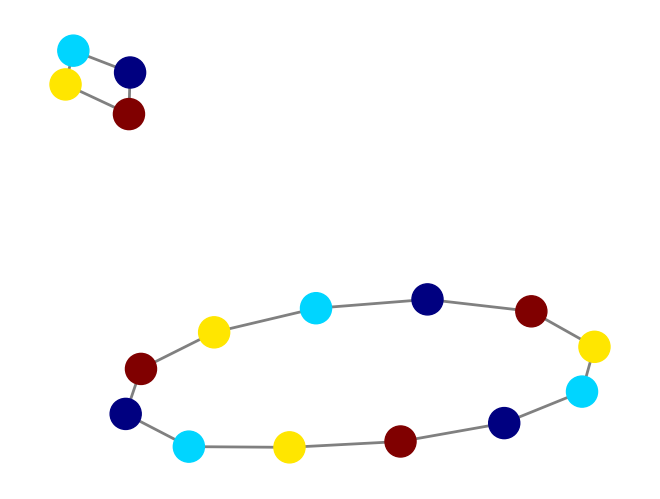

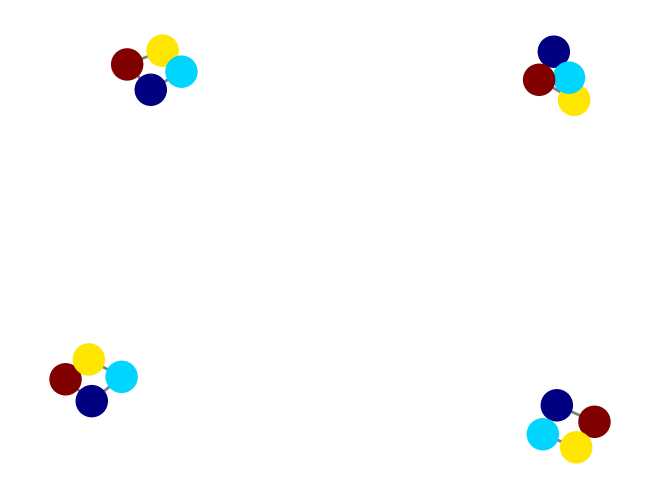

In [107]:
for g,_ in graphs:
    # g = nx.Graph()
    # g.add_nodes_from(np.arange(16))
    labels = np.argmax(np.vstack(tuple([X for _ in range(4)])), axis=1) 

    # Define the colormap
    cmap = plt.cm.jet  # Use the 'jet' colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]  # Extract all colors from the colormap
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    # Create the norm for the colormap
    unique_colors = np.unique(labels)  # Unique label indices
    bounds = np.linspace(0, len(unique_colors), len(unique_colors) + 1)  # Bounds for labels
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # Assign colors to nodes based on labels
    node_colors = [cmap(norm(label)) for label in labels]
    
    # Draw the graph
    pos = nx.spring_layout(g)
    nx.draw(
        g,
        pos,
        with_labels=False,
        node_size=500,
        node_color=node_colors,
        edge_color="grey",
        font_size=12,
        font_color="#333333",
        width=2,
    )
    plt.show()

In [6]:
X = np.array([[1,0],
              [1,0],
              [0,1],
              [0,1]])
O = np.array([[0,2],[2,0]])

In [7]:
g = nd.microcanonical_ensemble(X,O)

In [23]:
def probability_attempt(G,O,X):
    N = X.sum(axis=0)
    p = 1
    labels = np.argmax(X, axis=1)
    A = nx.adjacency_matrix(G).toarray()
    for i in range(N.sum()):
        for j in range(i+1,N.sum()):
            u,v=labels[i],labels[j]
            p_ij = np.min([O[u,v]/N[v] , O[v,u]/N[u]])
            p *= p_ij**(A[i,j])*(1-p_ij)**(1-A[i,j])
    return p

In [8]:
graphs = []
for i in range(1000):
    new_G = nd.microcanonical_ensemble(np.vstack(tuple([X for _ in range(2)])),O)
    count_graph_occurrences(graphs,new_G)

In [9]:
count = np.array([count for _, count in graphs])
count/count.sum()

array([0.186, 0.663, 0.151])

In [26]:
[probability_attempt(g,O,np.vstack(tuple([X for _ in range(2)]))) for g,_ in graphs]

[1.52587890625e-05, 1.52587890625e-05, 1.52587890625e-05]

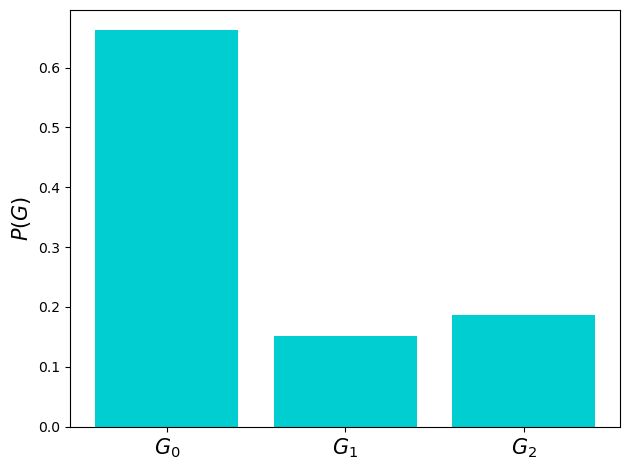

In [19]:
plt.bar(np.arange(len(graphs)),count[[1,2,0]]/count.sum(),color='darkturquoise')
plt.xticks([0,1,2],[f'$G_{i}$' for i in range(3)],fontsize=15)
plt.ylabel('$P(G)$',fontsize=15)
plt.tight_layout()
plt.savefig('figs/drafts/v5/fig2/hemoglobin_dist.pdf')
plt.show()
# plt.bar(np.arange(len(graphs)),[probability_attempt(g,O,np.vstack(tuple([X for _ in range(2)]))) for g,_ in graphs])

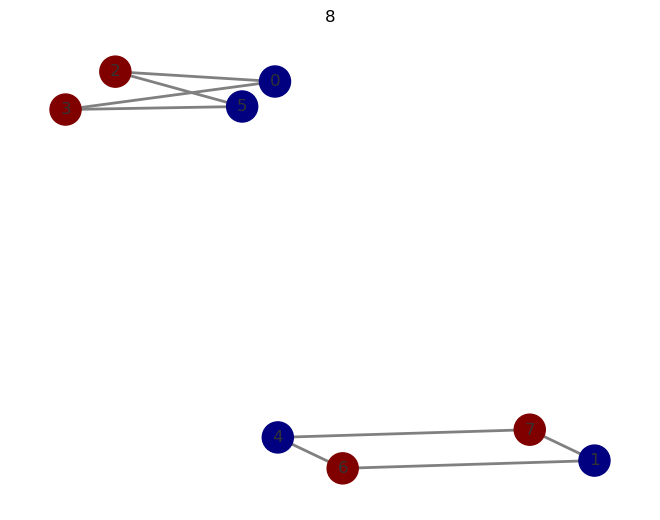

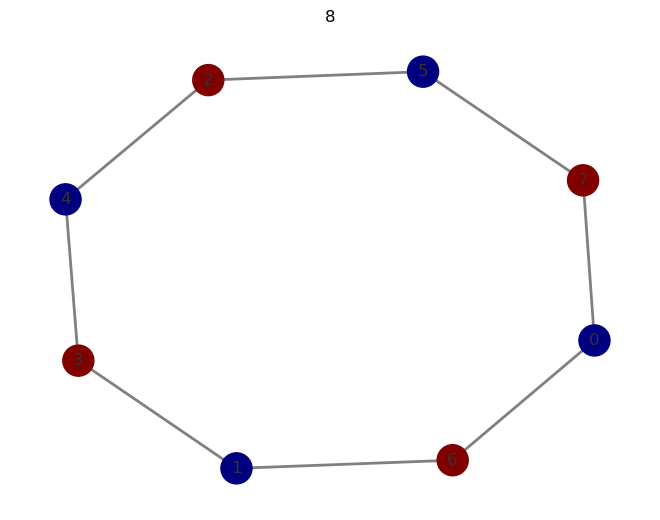

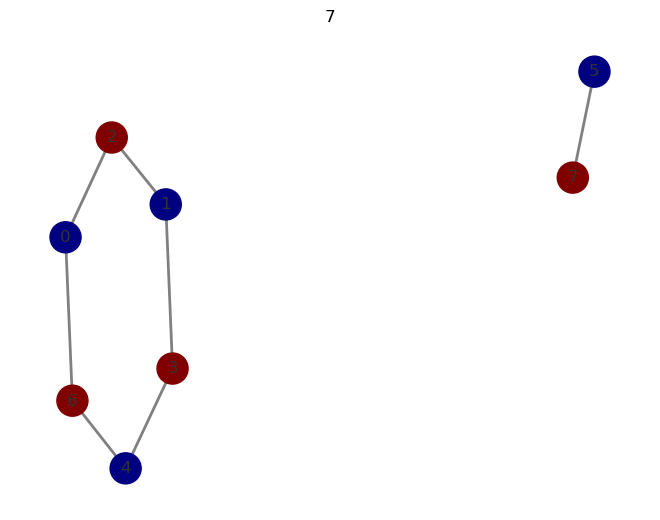

In [11]:
for g,_ in graphs:
    labels = np.argmax(np.vstack(tuple([X for _ in range(2)])), axis=1) 

    # Define the colormap
    cmap = plt.cm.jet  # Use the 'jet' colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]  # Extract all colors from the colormap
    cmap = mpl.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    # Create the norm for the colormap
    unique_colors = np.unique(labels)  # Unique label indices
    bounds = np.linspace(0, len(unique_colors), len(unique_colors) + 1)  # Bounds for labels
    norm = mpl.BoundaryNorm(bounds, cmap.N)
    
    # Assign colors to nodes based on labels
    node_colors = [cmap(norm(label)) for label in labels]
    
    # Draw the graph
    pos = nx.spring_layout(g, seed=14)
    nx.draw(
        g,
        pos,
        with_labels=True,
        node_size=500,
        node_color=node_colors,
        edge_color="grey",
        font_size=12,
        font_color="#333333",
        width=2,
    )
    plt.title(g.number_of_edges())
    plt.show()

In [51]:
g = nd.microcanonical_ensemble(X,O,directed=True)

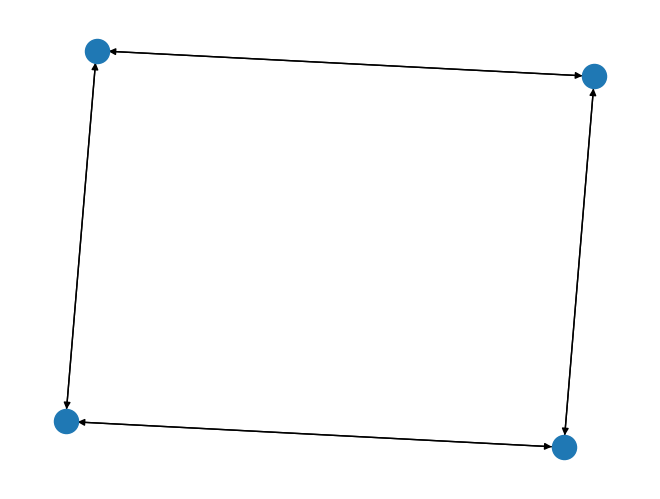

In [52]:
nx.draw(g)

In [69]:
def directed_to_bidirectional_undirected_fast(digraph):
    """
    Converts a directed graph to an undirected graph, retaining only edges
    that are bidirectional, using an optimized approach.
    
    Parameters:
    digraph (nx.DiGraph): A directed graph.

    Returns:
    nx.Graph: An undirected graph with only bidirectional edges.
    """
    # Create a set of directed edges
    directed_edges = set(digraph.edges())
    
    # Find bidirectional edges by checking for reverse edges
    bidirectional_edges = {(u, v) for u, v in directed_edges if (v, u) in directed_edges}
    
    # Create an undirected graph with the bidirectional edges
    undirected_graph = nx.Graph()
    undirected_graph.add_nodes_from(digraph.nodes())
    undirected_graph.add_edges_from(bidirectional_edges)
    
    return undirected_graph

In [55]:
undir_g = directed_to_bidirectional_undirected_fast(g)

In [70]:
dir_graphs = []
for i in range(1000):
    new_G = directed_to_bidirectional_undirected_fast(nd.microcanonical_ensemble(np.vstack(tuple([X for _ in range(6)])),O,directed=True))
    count_graph_occurrences(dir_graphs,new_G)

Traceback (most recent call last):
  File "/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_37258/1513446990.py", line 4, in <module>
    count_graph_occurrences(dir_graphs,new_G)
  File "/tmp/ipykernel_37258/3425939025.py", line 13, in count_graph_occurrences
    if nx.is_isomorphic(existing_graph, new_graph):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 16", line 3, in argmap_is_isomorphic_13
    import gzip
            ^^^^
  File "/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/networkx/utils/backends.py", line 633, in __call__
    return self.orig_func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/networkx/algorithms/isomorphism/isomorph.py", line 248, in is_isomorp

KeyboardInterrupt: 

In [105]:
g = nx.cycle_graph(4)
for i in range(5):
    g = nx.disjoint_union(g,nx.cycle_graph(4))

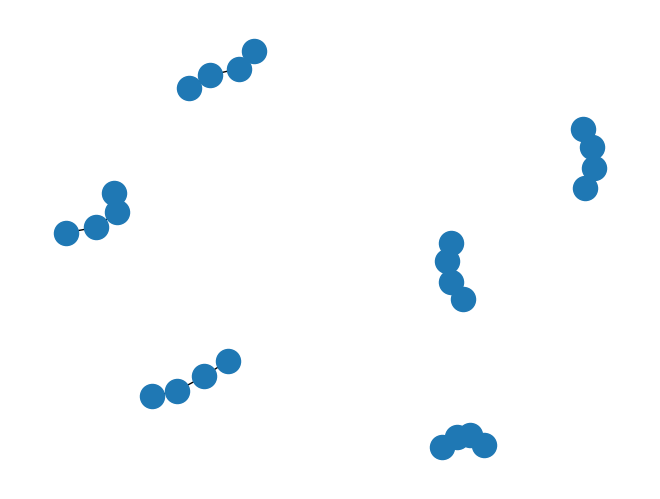

In [108]:
nx.draw(nx.maximum_spanning_tree(g))

In [78]:
count = np.array([count for _, count in dir_graphs])

In [85]:
links = np.array([g.number_of_edges() for g,_ in dir_graphs])

In [87]:
4*24

96

<BarContainer object of 34 artists>

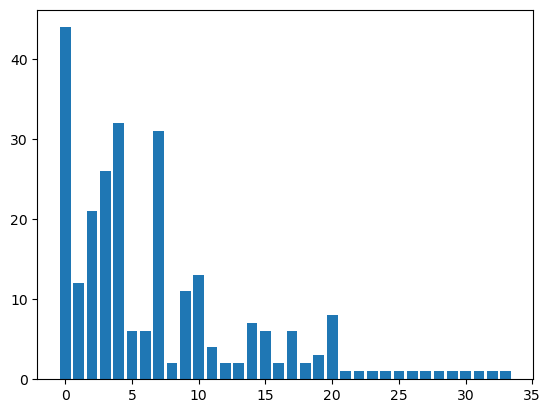

In [82]:
plt.bar(np.arange(len(dir_graphs)),count)

In [83]:
dir_graphs[0][0].edges()

EdgeView([(2, 4), (6, 16), (7, 12)])

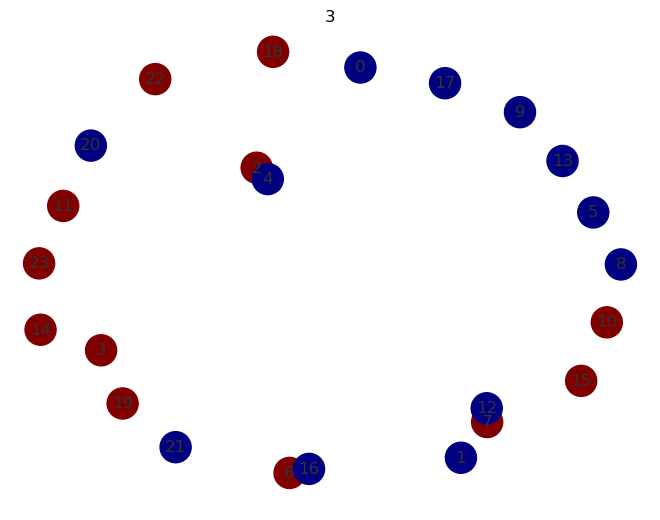

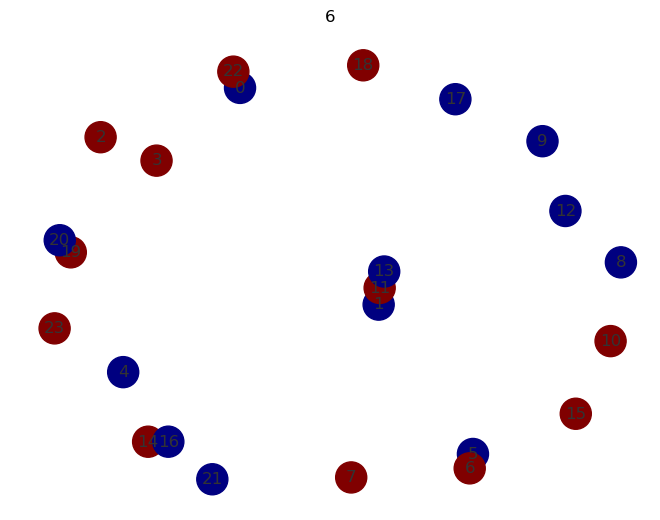

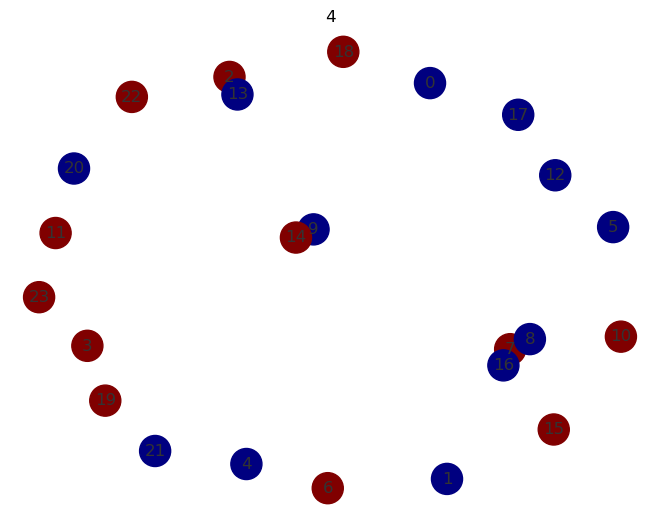

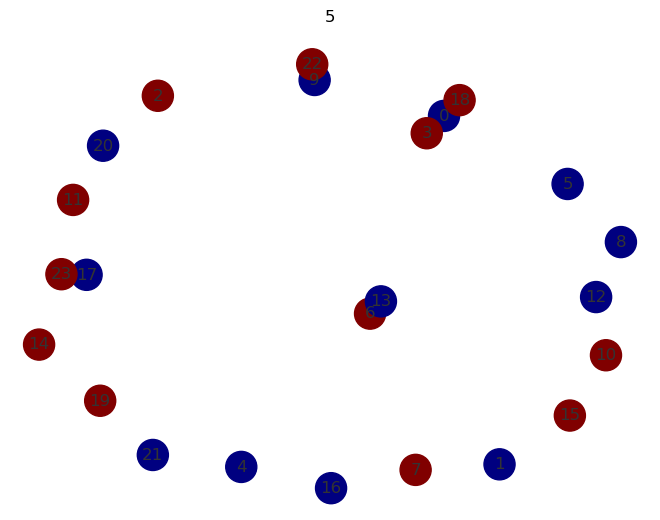

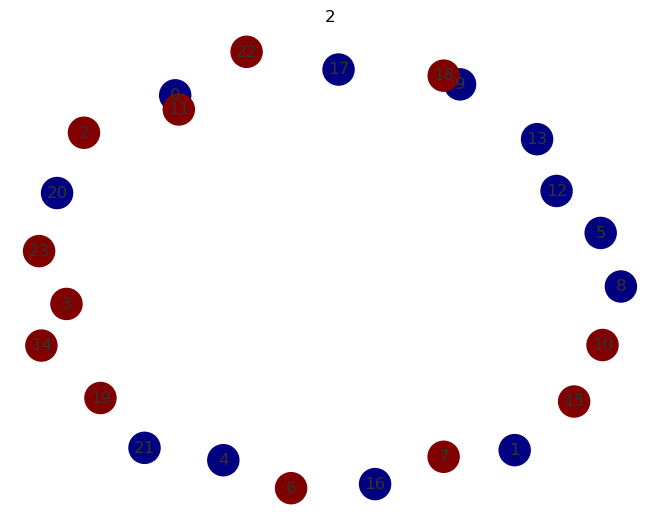

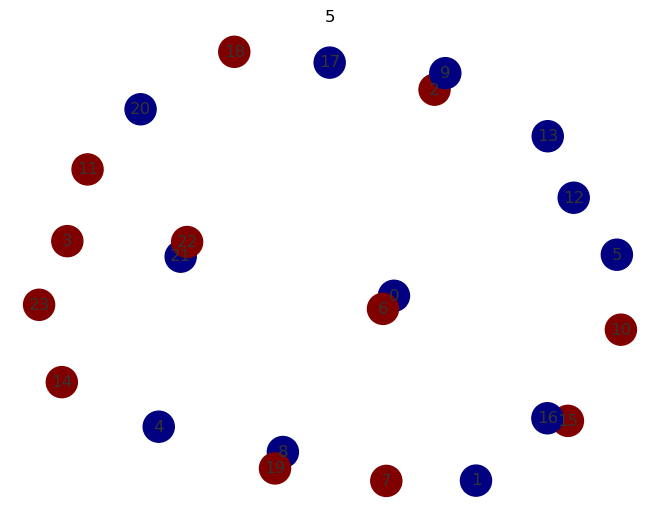

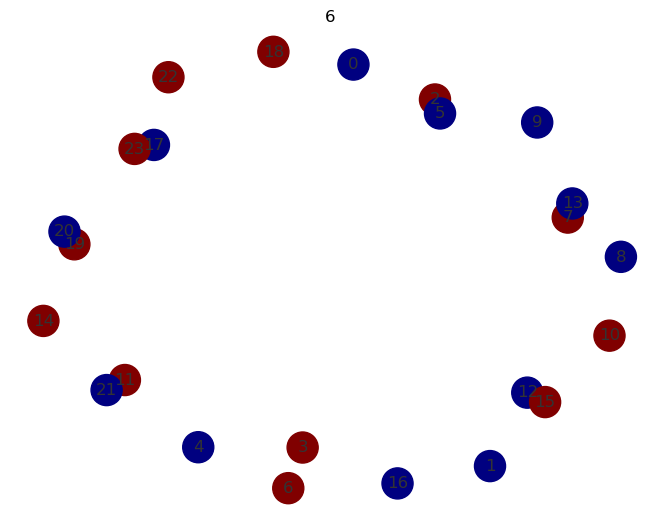

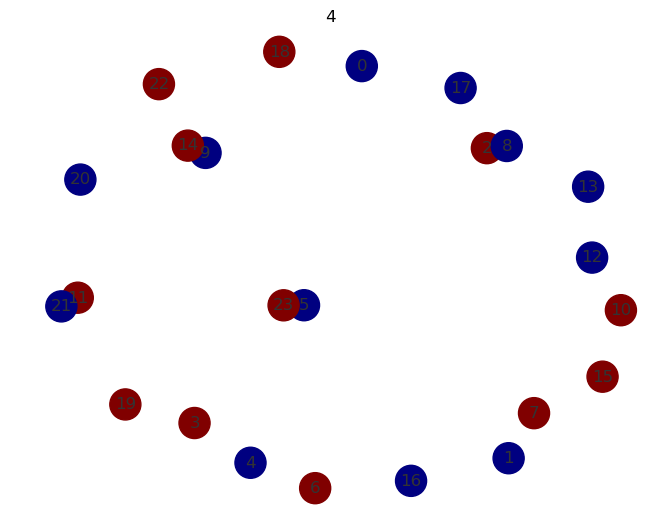

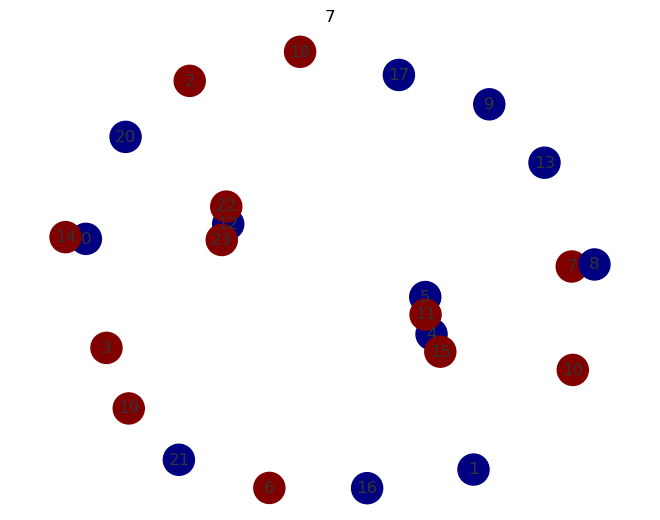

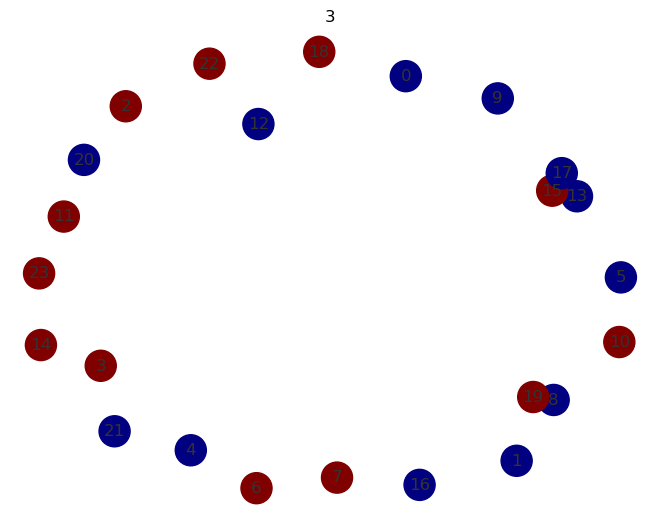

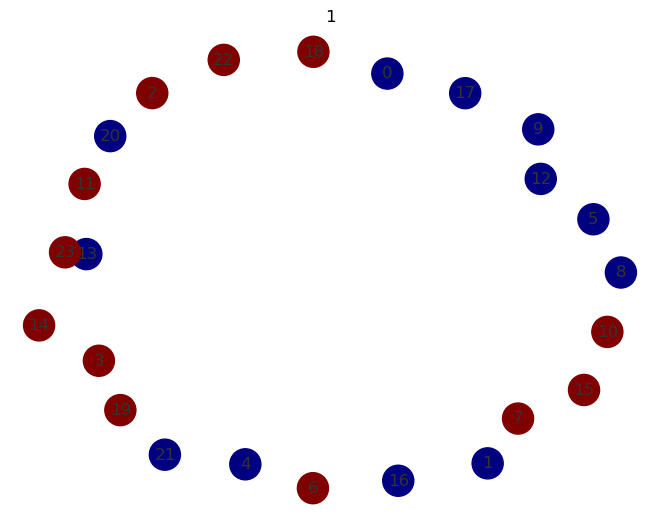

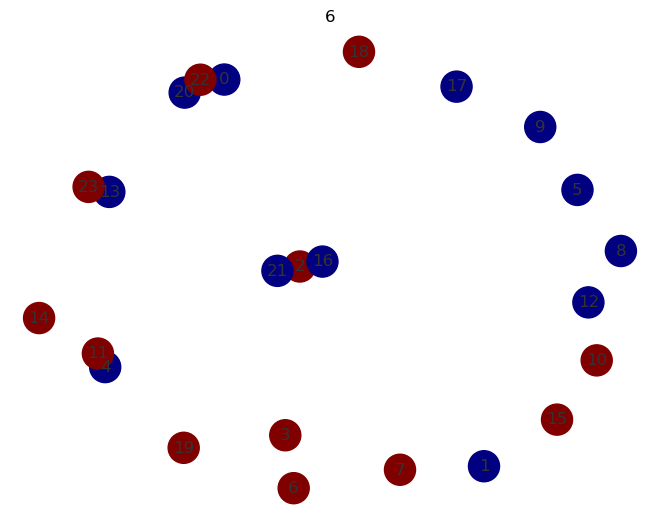

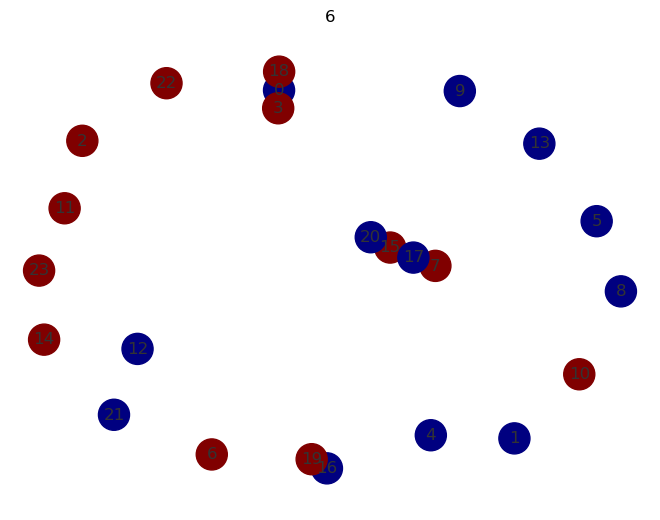

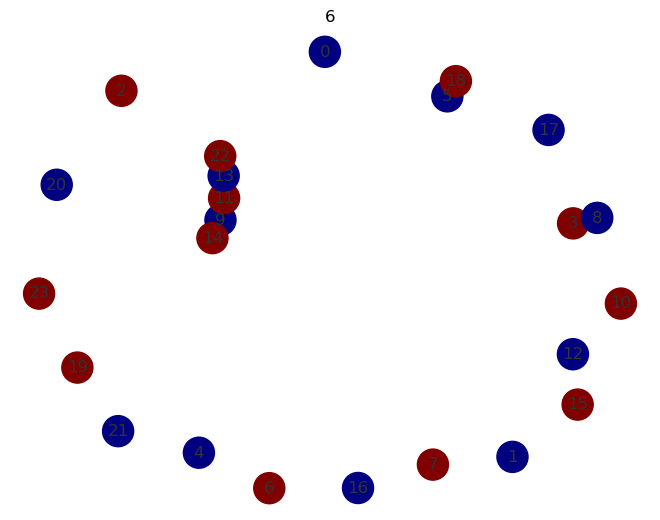

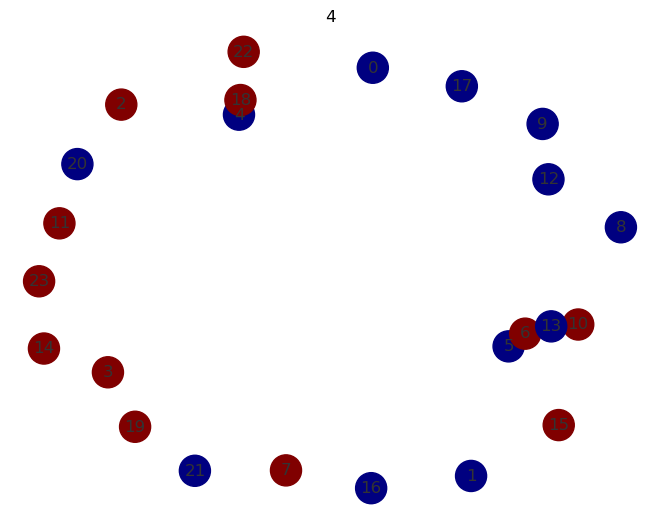

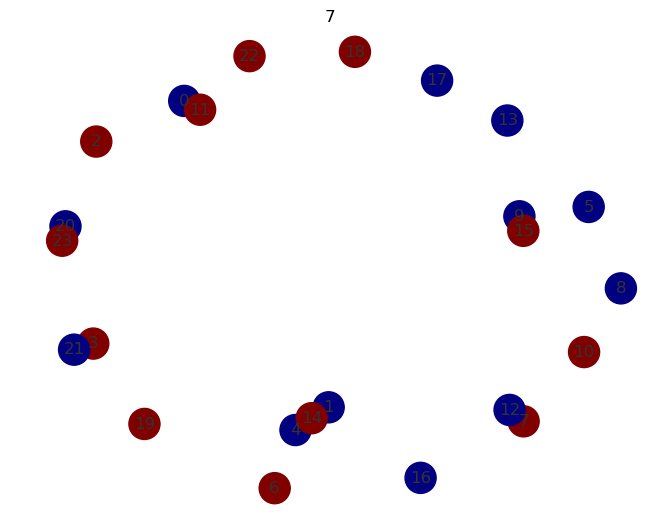

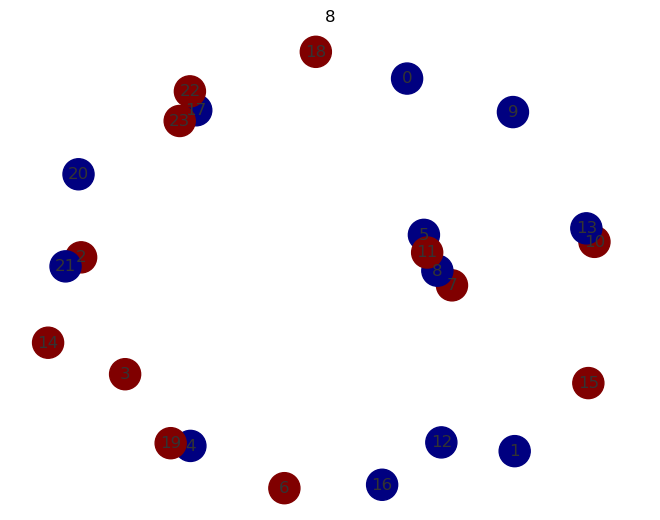

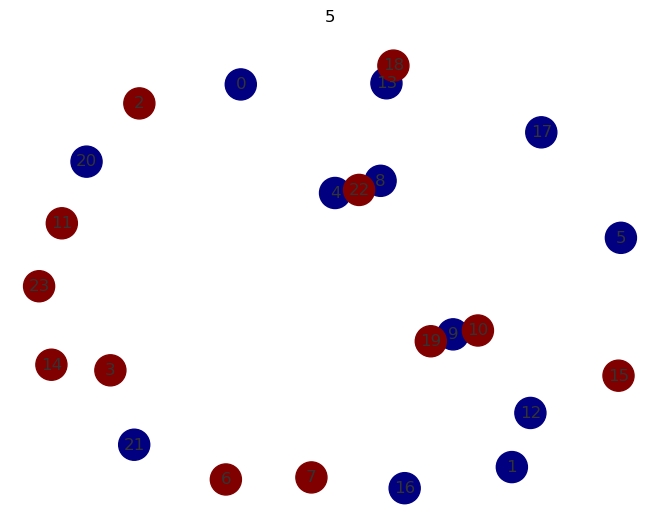

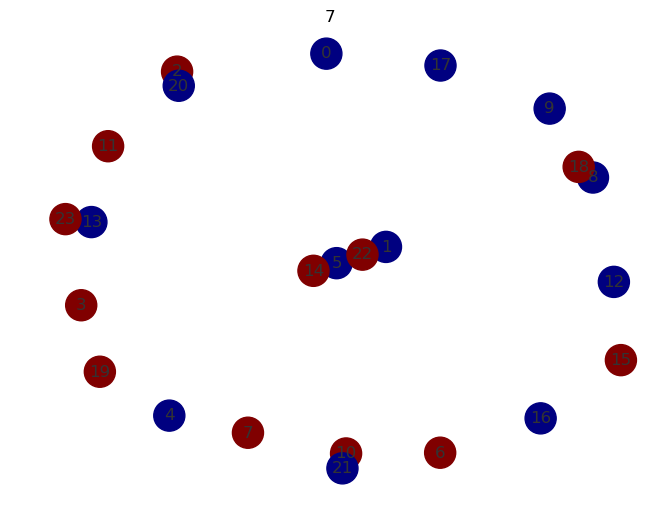

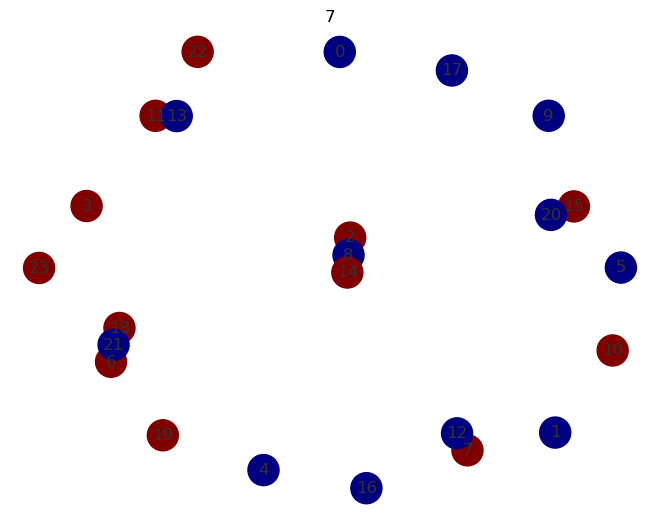

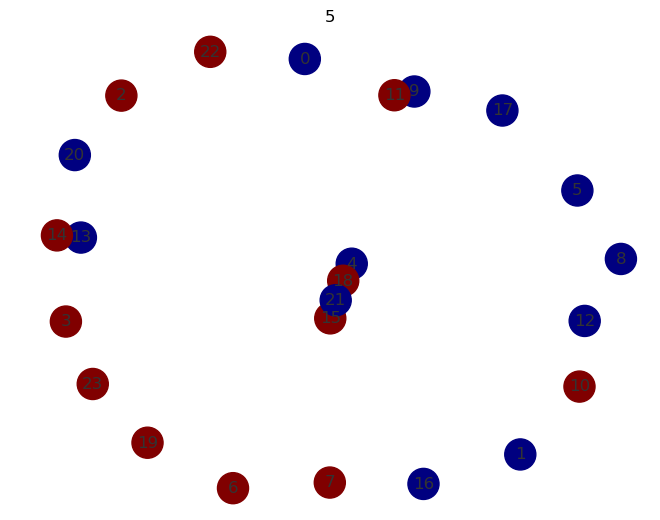

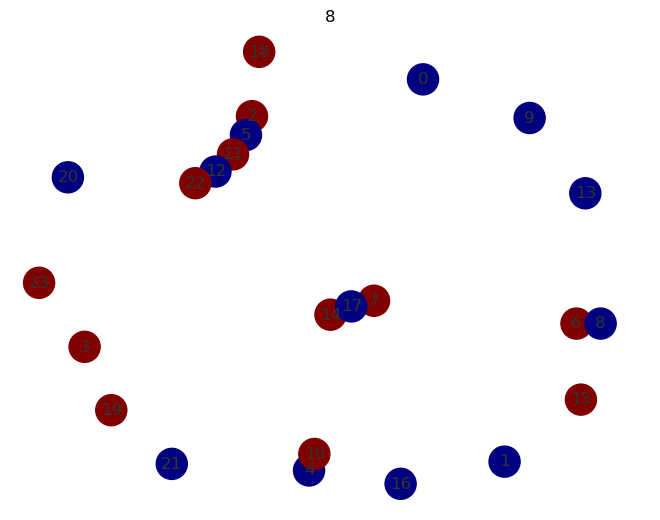

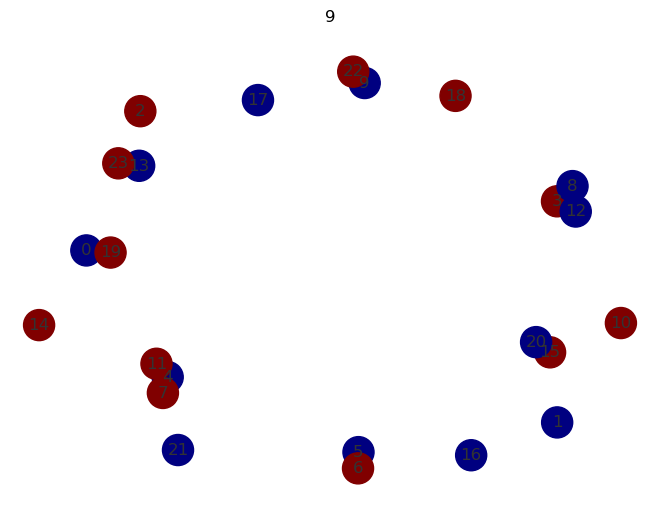

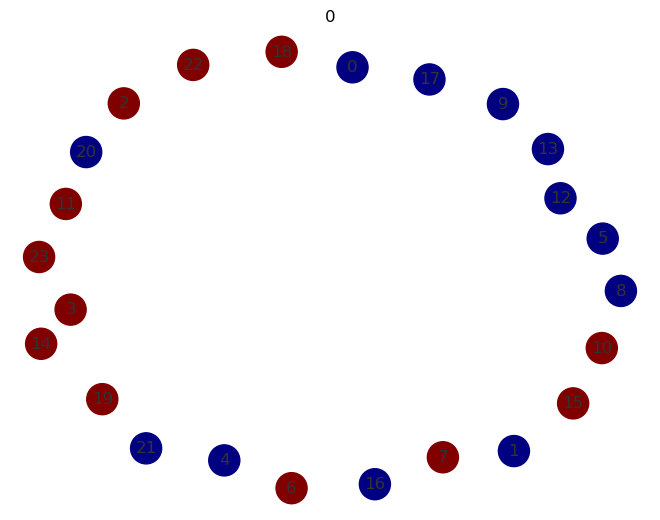

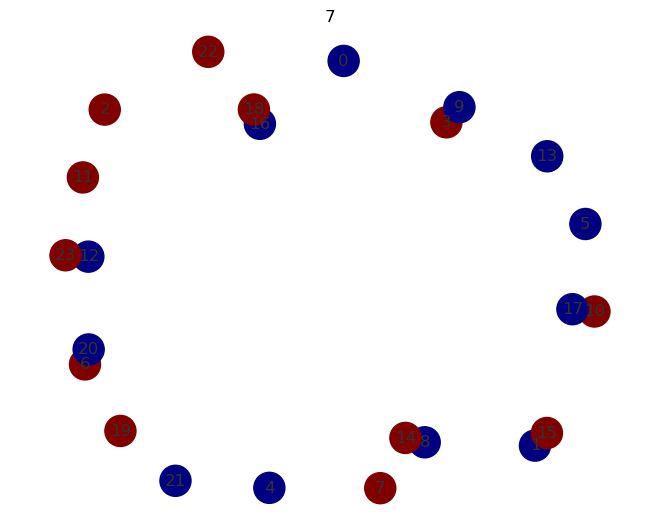

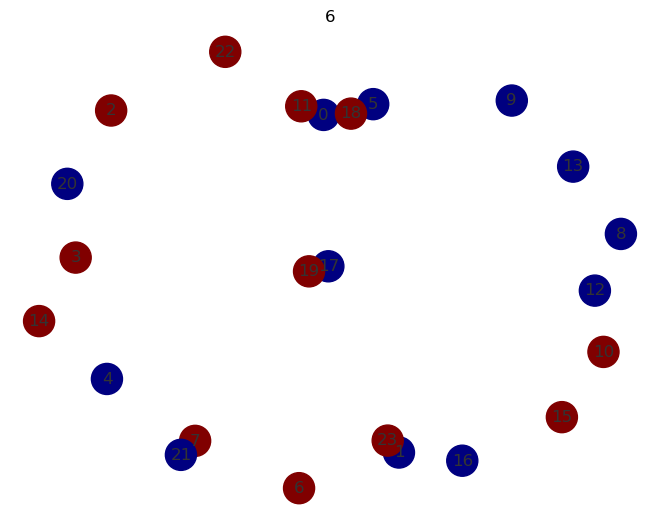

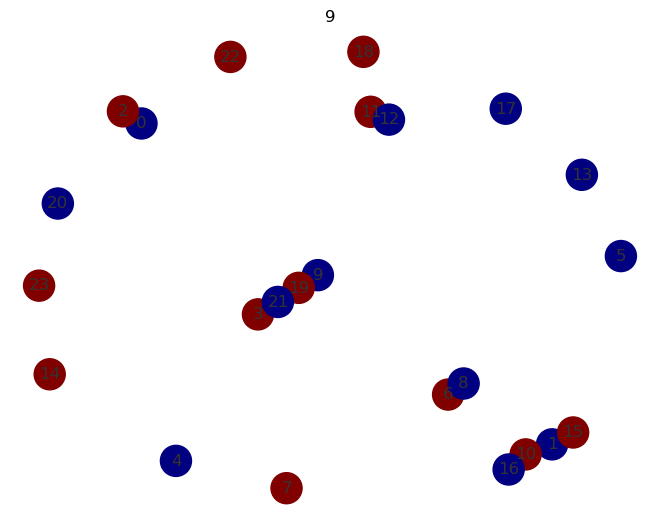

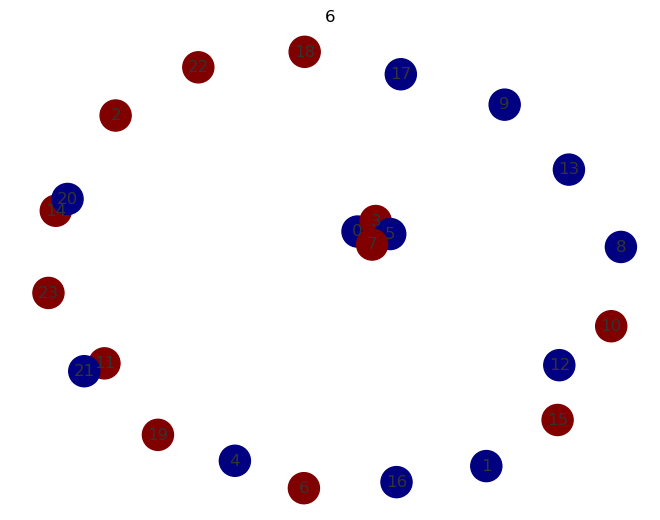

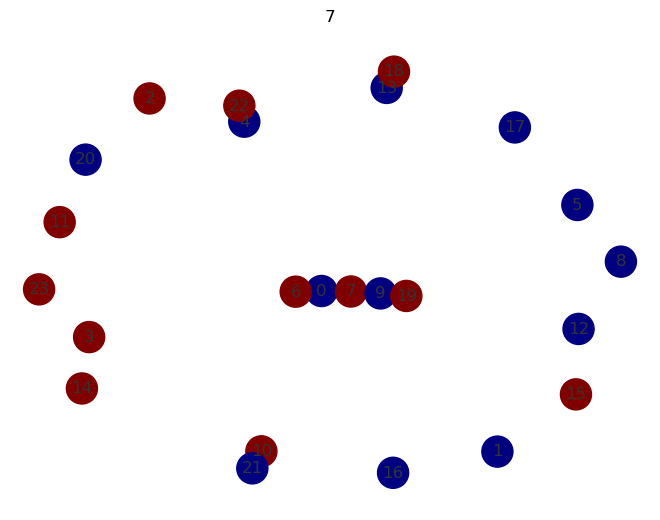

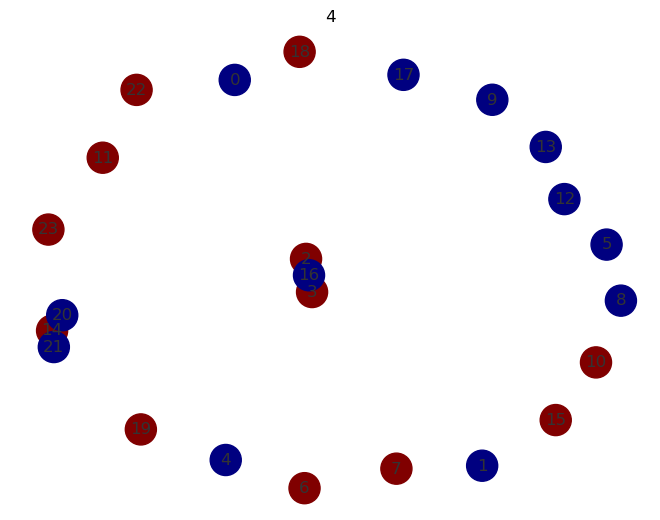

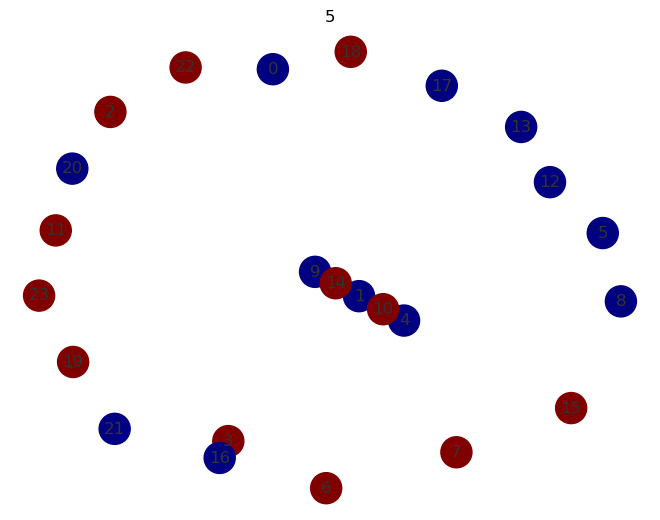

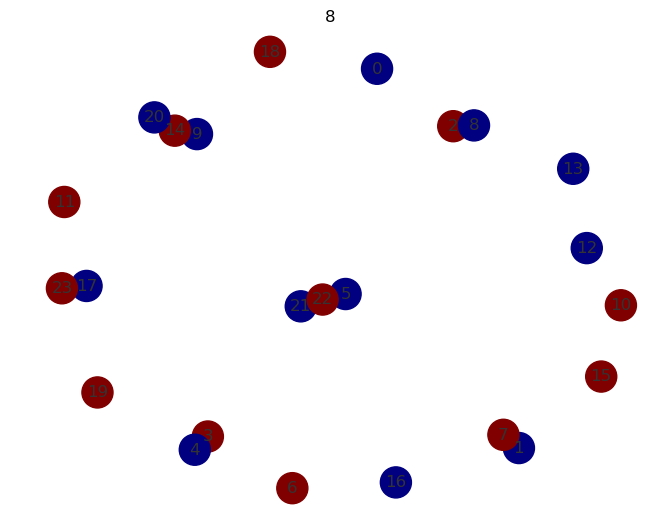

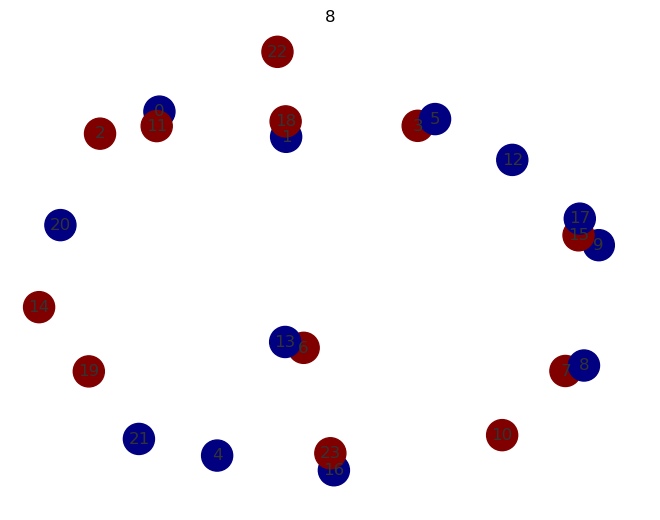

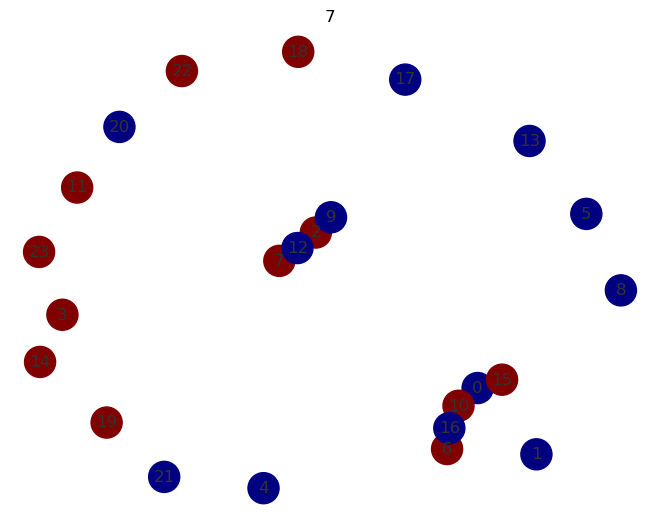

In [84]:
for g,_ in dir_graphs:
    labels = np.argmax(np.vstack(tuple([X for _ in range(6)])), axis=1) 

    # Define the colormap
    cmap = plt.cm.jet  # Use the 'jet' colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]  # Extract all colors from the colormap
    cmap = mpl.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    # Create the norm for the colormap
    unique_colors = np.unique(labels)  # Unique label indices
    bounds = np.linspace(0, len(unique_colors), len(unique_colors) + 1)  # Bounds for labels
    norm = mpl.BoundaryNorm(bounds, cmap.N)
    
    # Assign colors to nodes based on labels
    node_colors = [cmap(norm(label)) for label in labels]
    
    # Draw the graph
    pos = nx.spring_layout(g, seed=14)
    nx.draw(
        g,
        pos,
        with_labels=True,
        node_size=500,
        node_color=node_colors,
        edge_color="grey",
        font_size=12,
        font_color="#333333",
        width=2,
    )
    plt.title(g.number_of_edges())
    plt.show()

In [122]:
new_g = nd.canonical_ensemble(np.vstack(tuple([X for _ in range(6)])).sum(axis=0),O,np.vstack(tuple([X for _ in range(6)])))

In [130]:
nd.probability(nx.adjacency_matrix(graphs[-1][0]).toarray(),np.vstack(tuple([X for _ in range(6)])).sum(axis=0),O,np.vstack(tuple([X for _ in range(6)])))

0.0

In [131]:
O

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])

In [186]:
g = nx.cycle_graph(4)
X = np.eye(4)
O = nd.create_O(nd.extract_capacities(g,X))

In [29]:
def are_vertices_automorphic(graph, v1, v2):
    """
    Check if two vertices are automorphic in the graph.
    If they are automorphic, they are cospectral.
    """
    # Create a GraphMatcher to find automorphisms
    GM = GraphMatcher(graph, graph)
    
    # Check all automorphisms
    for automorphism in GM.isomorphisms_iter():
        # If v1 maps to v2, they are automorphic
        if automorphism[v1] == v2:
            return True
    return False

In [30]:
from networkx.algorithms.isomorphism import GraphMatcher

In [34]:
GM = GraphMatcher(g,g)

In [36]:
list(GM.isomorphisms_iter())

[{0: 0, 2: 2, 4: 4, 1: 1, 5: 5, 3: 3, 6: 6, 7: 7},
 {0: 0, 2: 2, 4: 4, 1: 1, 5: 5, 6: 3, 3: 6, 7: 7}]

In [3]:
import math

In [44]:
Z = math.factorial(8) / (2**4)

In [39]:
(24**2/32)/Z

0.11428571428571428

In [24]:
24**2/Z

0.22857142857142856

In [47]:
Z

2520.0

In [45]:
(2*24*24)/Z

0.45714285714285713

In [30]:
(2*8)*2/Z

0.012698412698412698

In [46]:
(2*24*24)

1152